### Configuración Inicial

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importamos todos los módulos que se van a utilizar y definimos funciones generales que se usan en distintas partes del trabajo.

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sklearn as sk
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV)
from sklearn.ensemble import (IsolationForest, RandomForestClassifier, GradientBoostingRegressor)
from sklearn import tree
from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn import metrics
from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    auc,
    log_loss,
    r2_score,
    silhouette_score,
    recall_score, 
    accuracy_score, 
    f1_score,
)
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

from tqdm import tqdm
from joblib import dump, load
from xgboost import XGBRegressor
from subprocess import call
from IPython.display import Image
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

import shapely

dataset = pd.read_csv("/content/drive/MyDrive/properati_argentina_2021.csv")
sns.set()

SEMILLA = 0
TEST_SIZE = 0.2


Creamos algunas funciones que nos serán de utilidad para obtener un código más prolijo.

In [91]:
def obtener_frecuencia_relativa(series):
    frecuencia_absoluta = series.value_counts()
    frecuencia_relativa = frecuencia_absoluta / frecuencia_absoluta.sum()
    return frecuencia_relativa


## Separación Train-Test

In [92]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=TEST_SIZE, random_state=SEMILLA
)

del(dataset)

## Filtrado del set de Training

Filtramos las propiedades que no vamos a utilizar para el analisis

In [93]:
def filtrado_de_propiedades(dataset):
    filtro_tipo_propiedad = ["casa", "ph", "departamento"]
    filtro_operacion = ["venta"]
    filtro_ubicacion = ["capital federal"]
    filtro_moneda = ["usd"]

    filtros = {
        "property_type": filtro_tipo_propiedad,
        "operation": filtro_operacion,
        "place_l2": filtro_ubicacion,
        "property_currency": filtro_moneda,
    }

    for columna in filtros:
        dataset[columna] = dataset[columna].str.lower()

    for columna_a_filtrar, filtro in filtros.items():
        dataset = dataset[dataset[columna_a_filtrar].isin(filtro)]

    return dataset


dataset_train = filtrado_de_propiedades(dataset_train)
dataset_test = filtrado_de_propiedades(dataset_test)

del(filtrado_de_propiedades)



Eliminamos columnas innecesarias, que no utilizaremos para el analisis

In [94]:
def eliminar_columnas_innecesarias(dataset):
    columnas_eliminar = [
      "property_title",
      "id",
      "place_l4",
      "place_l5",
      "place_l6",
      "property_currency",
      "operation",
      "place_l2",
      "start_date",
      "end_date",
      "created_on"
    ]

    dataset.drop(columnas_eliminar, axis=1, inplace=True)

    return dataset


dataset_train = eliminar_columnas_innecesarias(dataset_train)
dataset_test = eliminar_columnas_innecesarias(dataset_test)

del(eliminar_columnas_innecesarias)


Estandarizamos la columna barrio

In [95]:
def estandarizar_barrio(dataset):
  dataset = dataset.rename(columns={"place_l3": "barrio"})
  dataset["barrio"] = dataset["barrio"].apply(
    lambda barrio: barrio if type(barrio) == str else None
  )
  
  return dataset


dataset_train = estandarizar_barrio(dataset_train)
dataset_test = estandarizar_barrio(dataset_test)

del(estandarizar_barrio)


Estandarizamos las columnas de superficie

In [96]:
def estandarizar_superficie(fila):
    if fila["property_surface_total"] < 30:
        fila["property_surface_total"] = np.nan
    if fila["property_surface_covered"] < 30:
        fila["property_surface_covered"] = np.nan

    return fila


dataset_train = dataset_train.apply(estandarizar_superficie, axis=1)
dataset_test = dataset_test.apply(estandarizar_superficie, axis=1)

del(estandarizar_superficie)


 ## Análisis de Valores Atípicos Univariados

Eliminamos los valores atipicos univariados, utilizando el rango intercuartil

In [97]:
def obtener_limites_iqr(columna):
    q25 = columna.quantile(0.25)
    q75 = columna.quantile(0.75)
    rango = q75 - q25
    
    lim_superior = q75 + (rango * 3)
    lim_inferior = q25 - (rango * 3)

    return (lim_superior, lim_inferior)

def filtro_columna_por_limites(columna, inferior, superior):
    return (columna <= superior) & (columna >= inferior)

def eliminar_atipicos(dataset_train, dataset_test):
    columnas_cuantitativas = [
      "property_rooms",
      "property_bedrooms",
      "property_surface_total",
      "property_surface_covered",
      "property_price",
    ]

    for columna in columnas_cuantitativas:
      superior, inferior = obtener_limites_iqr(dataset_train[columna])
      
      filtro = filtro_columna_por_limites(dataset_train[columna], inferior, superior)
      dataset_train = dataset_train[filtro]

      filtro = filtro_columna_por_limites(dataset_test[columna], inferior, superior)
      dataset_test = dataset_test[filtro]

    return (dataset_train, dataset_test)

dataset_train, dataset_test = eliminar_atipicos(dataset_train, dataset_test)

del(obtener_limites_iqr)
del(filtro_columna_por_limites)
del(eliminar_atipicos)




Eliminamos los casos donde la superficie cubierta es mayor a la superficie total

In [98]:
dataset_train = dataset_train[
    ~(dataset_train.property_surface_covered > dataset_train.property_surface_total)
]
dataset_train = dataset_train[
    ~(dataset_train.property_bedrooms > dataset_train.property_rooms)
]

dataset_test = dataset_test[
    ~(dataset_test.property_surface_covered > dataset_test.property_surface_total)
]
dataset_test = dataset_test[
    ~(dataset_test.property_bedrooms > dataset_test.property_rooms)
]


Graficamos la distribución de cantidad de datos faltantes por fila. 


Vemos que quedan pocas filas con datos faltantes, por lo que podemos imputarlas.

## Imputación de datos faltantes

### Imputación de `property_bedrooms`, `property_rooms`, `property_price`

Anteriormente observamos que existe una correlación entre `property_bedrooms`, `property_rooms` y `property_price`. Podemos entrenar un modelo lineal para predecir los datos faltantes.

Imputamos las columnas `property_bedrooms`, `property_rooms` y `property_price` utilizando un imputador iterativo con un modelo lineal

In [99]:
columnas_a_imputar = ["property_bedrooms", "property_rooms", "property_price"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    min_value=(1, 1, 50000),
    max_iter=20,
    random_state=SEMILLA,
)

imp.fit(dataset_train[columnas_a_imputar])


def imputar_columnas(modelo, dataset, columnas_a_imputar):
    columnas_imputadas = modelo.transform(dataset[columnas_a_imputar])
    return pd.DataFrame(columnas_imputadas, columns=columnas_a_imputar).astype(int)


dataset_imputado = imputar_columnas(imp, dataset_train, columnas_a_imputar)
dataset_test_imputado = imputar_columnas(imp, dataset_test, columnas_a_imputar)


Observamos que tienen la misma distribución que los datos originales.

[Text(0.5, 0, 'precio de propiedad (usd)'),
 Text(0.5, 1.0, 'Distribución de precio de propiedad (imputado)')]

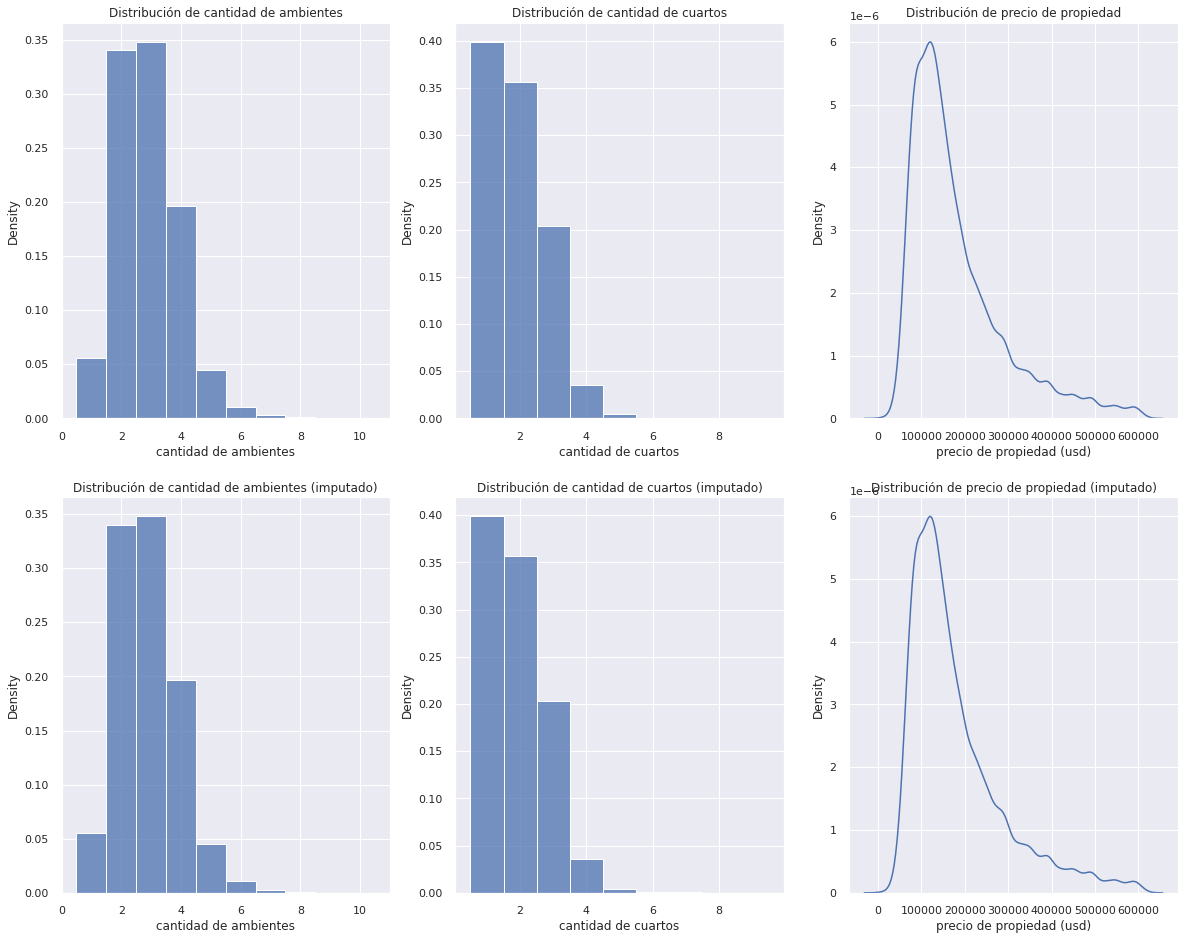

In [101]:
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 16))

ax = sns.histplot(
    ax=axes[0][0], x=dataset_train.property_rooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de ambientes", xlabel="cantidad de ambientes")

ax = sns.histplot(
    ax=axes[0][1], x=dataset_train.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de cuartos", xlabel="cantidad de cuartos")

ax = sns.kdeplot(ax=axes[0][2], x=dataset_train.property_price)
ax.set(title="Distribución de precio de propiedad", xlabel="precio de propiedad (usd)")

ax = sns.histplot(
    ax=axes[1][0], x=dataset_imputado.property_rooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de ambientes (imputado)",
    xlabel="cantidad de ambientes",
)

ax = sns.histplot(
    ax=axes[1][1], x=dataset_imputado.property_bedrooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de cuartos (imputado)", xlabel="cantidad de cuartos"
)

ax = sns.kdeplot(ax=axes[1][2], x=dataset_imputado.property_price)
ax.set(
    title="Distribución de precio de propiedad (imputado)", xlabel="precio de propiedad (usd)"
)


Actualizamos los valores imputados en el nuevo dataframe y vemos que las columnas imputadas ya no tienen valores faltantes.

In [102]:
dataset_test[columnas_a_imputar] = dataset_test_imputado[columnas_a_imputar].values
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


latitud                     1938
longitud                    1938
barrio                       112
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputación de `property_surface_covered`, `property_surface_total`


También habíamos observado una correlación entre `property_surface_covered`, `property_surface_total` por lo que podemos entrenar otro modelo lineal para predecir estos datos faltantes. 

Imputamos los datos utilizando un imputador iterativo.

In [103]:
columnas_a_imputar = ["property_surface_covered", "property_surface_total"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    max_iter=20,
    min_value=(30, 30),
    verbose=0,
    random_state=SEMILLA,
)

imp.fit(dataset_train[columnas_a_imputar])

dataset_imputado = imputar_columnas(imp, dataset_train, columnas_a_imputar)
dataset_test_imputado = imputar_columnas(imp, dataset_test, columnas_a_imputar)


Observamos que tienen una distribución parecida a la de los datos originales.

[Text(0.5, 0, 'superficie total (m2)'),
 Text(0.5, 1.0, 'Distribución de superficie total (imputado)')]

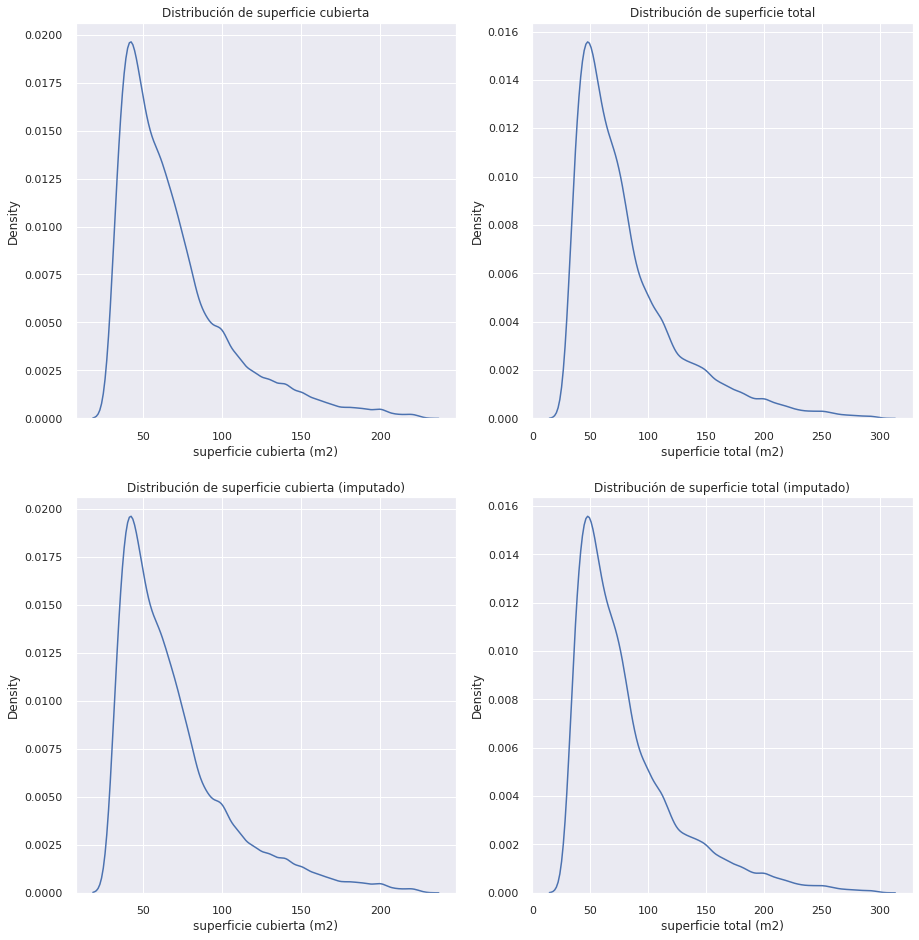

In [104]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 16))

ax = sns.kdeplot(ax=axes[0][0], x=dataset_train.property_surface_covered)
ax.set(title="Distribución de superficie cubierta", xlabel="superficie cubierta (m2)")

ax = sns.kdeplot(ax=axes[0][1], x=dataset_train.property_surface_total)
ax.set(title="Distribución de superficie total", xlabel="superficie total (m2)")

ax = sns.kdeplot(ax=axes[1][0], x=dataset_imputado.property_surface_covered)
ax.set(
    title="Distribución de superficie cubierta (imputado)", xlabel="superficie cubierta (m2)"
)

ax = sns.kdeplot(ax=axes[1][1], x=dataset_imputado.property_surface_total)
ax.set(title="Distribución de superficie total (imputado)", xlabel="superficie total (m2)")


Observamos que la distribución es levemente distinta, apareciendo más datos con un valor entre 50 y 100; podemos suponer que sucede porque el modelo realiza una imputación por mediana. 

Actualizamos los valores imputados en el nuevo dataframe y observamos que ahora las columnas imputadas ya no tienen datos nulos.

In [105]:
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values
dataset_test[columnas_a_imputar] = dataset_test_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


latitud                     1938
longitud                    1938
barrio                       112
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputacion `barrio` por `coordenadas`

Podemos entrenar un modelo que pueda predecir el barrio a partir de las coordenadas.

In [106]:
dataset_forest = dataset_train.copy()
dataset_forest.dropna(inplace=True)

factorizacion_barrio = pd.factorize(dataset_forest["barrio"])
dataset_forest["barrio"] = factorizacion_barrio[0]
definiciones_barrio = factorizacion_barrio[1]

atributos = ["latitud", "longitud"]

target = "barrio"

X = dataset_forest[atributos]
y = dataset_forest[target]

clasificador_rfc = DecisionTreeClassifier(
    random_state=SEMILLA,
)


Separamos en train y test, y escalamos los datos para mayor performance.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEMILLA
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Ahora, entrenamos el modelo y vemos su desempeño

In [108]:
clasificador_rfc.fit(X_train, y_train)
print("Accuracy: ", clasificador_rfc.score(X_test, y_test))

Accuracy:  0.8231771080901227


El desempeño es excelente, lo podemos utilizar para imputar los barrios faltantes. Sin embargo, solo lo podemos aplicar en filas que contengan ambas coordenadas.

In [109]:
def imputar_barrio(fila):
    if fila["barrio"] != None:
        return fila

    if fila[atributos].isna().any():
        return fila

    barrio = clasificador_rfc.predict([fila[atributos].copy()])

    fila["barrio"] = definiciones_barrio[barrio[0]]

    return fila


dataset_train = dataset_train.apply(imputar_barrio, axis=1)
dataset_test = dataset_test.apply(imputar_barrio, axis=1)


Observamos la distribución de faltantes hasta ahora.

In [110]:
dataset_train.isna().sum()


latitud                     1938
longitud                    1938
barrio                        48
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputación de `latitud`, `longitud` según `barrio`

Primero, buscamos el punto medio de cada barrio, para luego reemplazarlo en las coordenadas faltantes.

In [111]:
columnas_ubicacion = ["latitud", "longitud", "barrio"]
dataset_ubicaciones = dataset_train[columnas_ubicacion]
promedio_ubicaciones = dataset_ubicaciones.groupby("barrio").mean()


Ahora, podemos reemplazar los datos de latitud y longitud faltantes con el promedio para el barrio al que pertenecen.

In [112]:
def imputar_cordenada(fila):
    barrio = fila["barrio"]

    if barrio == None:
        return fila

    if np.isnan(fila["latitud"]):
        fila["latitud"] = promedio_ubicaciones.at[barrio, "latitud"]

    if np.isnan(fila["longitud"]):
        fila["longitud"] = promedio_ubicaciones.at[barrio, "longitud"]

    return fila


dataset_train = dataset_train.apply(imputar_cordenada, axis=1)
dataset_test = dataset_test.apply(imputar_cordenada, axis=1)


Observamos la distribución de datos faltantes.

In [113]:
dataset_train.isna().sum()


latitud                     48
longitud                    48
barrio                      48
property_type                0
property_rooms               0
property_bedrooms            0
property_surface_total       0
property_surface_covered     0
property_price               0
dtype: int64

### Datos Faltantes Restantes

Finalmente, tenemos una cantidad muy baja de valores faltantes en la ubicación. Los podemos quitar para facilitar los análisis posteriores.

In [114]:
dataset_train = dataset_train[~dataset_train.barrio.isna()]
dataset_test = dataset_test[~dataset_test.barrio.isna()]


In [115]:
dataset_train.isna().sum()


latitud                     0
longitud                    0
barrio                      0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
dtype: int64

## Análisis de Valores Atípicos Multivariados

Al intentar aplicar la medida de distancia Mahalanobis el algoritmo no funcionaba ya que multiplicar matrices de dimensiones tan altas requería de una cantidad de memoria RAM demasiado grande. Por otro lado, el algoritmo LOF tampoco funcionaba del todo bien ya que la información no está ordenada en clusters, por lo que los cálculos de densidad no daban bien. Debido a esto, decidimos aplicar `IsolationForest` para analizar la presencia de valores atípicos multivariados.  

### Isolation Forest para `property_surface_total` y `property_price`

Ahora vamos a analizar la distribución de valores atipicos en únicamente las columnas `property_surface_total` y `property_price`.

Graficamos la distribución de estas variables en un **scatter plot**.

[Text(0, 0.5, 'property price (usd)'),
 Text(0.5, 0, 'property surface total (m^2)'),
 Text(0.5, 1.0, 'Distribución de superficie total vs precio')]

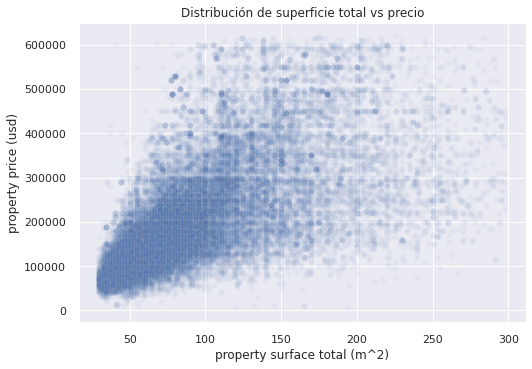

In [116]:
sns.scatterplot(
    data=dataset_train, x="property_surface_total", y="property_price", alpha=0.05
).set(title = "Distribución de superficie total vs precio", xlabel="property surface total (m^2)", ylabel="property price (usd)")


Observamos que hay mucha concentración, con algunas observaciones dispersas. Realizamos otro `isolation forest` para identificarlas. 

Notamos también una concentración de valores entre 50 y 100, lo que seguramente se debe al cambio en la distribución que se observó en la imputación de `property_surface_total`.

In [117]:
columnas = [
    "property_surface_total",
    "property_price",
]

dataset_isolation_forest = dataset_train[columnas].copy()
n_samples = dataset_isolation_forest.shape[0] // 4

iforest = IsolationForest(
    n_estimators=100,
    max_samples=n_samples,
    contamination=0.005,
    max_features=len(columnas),
    bootstrap=True,
    n_jobs=-1,
    random_state=SEMILLA,
)

dataset_isolation_forest["outlier"] = iforest.fit_predict(dataset_isolation_forest)
dataset_isolation_forest["outlier"] = dataset_isolation_forest["outlier"].replace(
    to_replace=[-1, 1], value=[True, False]
)

print("Cantidad de observaciones anómalas:")
print(dataset_isolation_forest["outlier"].value_counts())


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


Cantidad de observaciones anómalas:
False    54274
True       273
Name: outlier, dtype: int64


Graficamos la distribución de outliers encontrada.

[Text(0, 0.5, 'property price (usd)'),
 Text(0.5, 0, 'property surface total (m^2)'),
 Text(0.5, 1.0, 'Distribución de superficie total vs precio')]

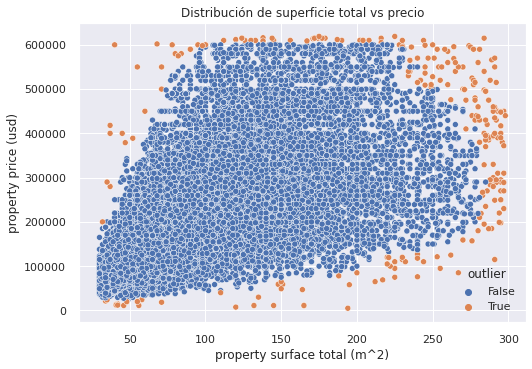

In [118]:
sns.scatterplot(
    data=dataset_isolation_forest,
    x="property_surface_total",
    y="property_price",
    hue="outlier",
).set(title = "Distribución de superficie total vs precio", xlabel="property surface total (m^2)", ylabel="property price (usd)")

Observamos que marca pocos valores que en el gráfico se aprecian como atípicos (por ejemplo, `property_surface_total` alto con `property_price` bajo) por lo que los quitamos para continuar el análisis.

In [119]:
dataset_train = dataset_train[~dataset_isolation_forest.outlier]


## Exportacion de Datasets

In [120]:
dataset_train.to_csv("train.csv")
dataset_test.to_csv("test.csv")